<a href="https://colab.research.google.com/github/dora-jpg/Vaccine-Sentiment-Classifier/blob/main/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Intelligence II - Softmax Regression
In this exercise we are going to use Softmax Regression to train a model that predicts the vaccine sentiment of a tweet. We have 3 classes: neutral, antivax and pro-vax.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries and Read Datasets

In [ ]:
import pandas as pd
import numpy as np
# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Feature-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
# For softmax regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
# Evaluation metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

Read train and validation datasets

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/vaccine_train_set.csv")
df_validation = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/vaccine_validation_set.csv")

 We don't need the first column of the datasets because it is an index.

In [ ]:
# get rid of first column
df_train = df_train.iloc[: , 1:]
df_validation = df_validation.iloc[: , 1:]

In [ ]:
display(df_train.head())
df_train.describe()

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


,label
count,15976.000000
mean,0.936592
std,0.930740
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


In [ ]:
display(df_validation.head())
df_validation.describe()

,tweet,label
0,@user They had a massive surge in with covid d...,1
1,Required vaccines for school: Parents and guar...,0
2,“@KCStar: Two more Johnson County children hav...,0
3,NV can do better. Which states are the best (a...,2
4,Nothing like killing ourselves w/ our own fear...,2


,label
count,2282.000000
mean,0.936897
std,0.930960
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


## Data Pre-processing

In [ ]:
#Check for null values
#In this case there are no missing values, so no action is needed
df_train.isnull().sum()

tweet    0
label    0
dtype: int64

In [ ]:
df_validation.isnull().sum()

tweet    0
label    0
dtype: int64

### Stemming & cleaning

Stemming is reducing a word to its base word or stem in such a way that the words of similar kind lie under a common stem.

In [ ]:
import nltk
from collections import defaultdict
from nltk.stem.snowball import SnowballStemmer
import gensim
from nltk import word_tokenize

nltk.download('punkt')
stemmer = SnowballStemmer(language='english')
all_stopwords = gensim.parsing.preprocessing.STOPWORDS

def stem_text(text):
  text = text.replace("#", "  ")
  tokens = word_tokenize(text.lower())
  text = ' '.join([ token for token in tokens if (token not in all_stopwords and len(token)>2 and "@" not in token and token.isalpha()) ])

  return text

def preprocessing2(df):
  df = df[~df.tweet.isna()] # remove NA values
  df['tweet'] = df['tweet'].apply(stem_text)
  
  return df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# df_train = preprocessing2(df_train)
# df_validation = preprocessing2(df_validation)

Stemming was worse than no preprocessing for our dataset, so the code that applies it is commented out. I used Lemmatization instead. 

### Lematizing & cleaning

Lemmatizing matches each word to a dictionary of words so that synonyms and variations of the same word don't count as different words at the feature extraction step.


In [ ]:
# Dictionary is created where pos_tag (first letter) are the key values whose values are mapped with the value from wordnet dictionary. 
# We have taken the only first letter as we will use it later in the loop.

# For preprocessing
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
# the corpus reader wordnet is imported.
from nltk.corpus import wordnet as wn
# WordNetLemmatizer is imported from wordnet.
from nltk.stem.wordnet import WordNetLemmatizer
# Word tokenize as well as parts of speech tag are imported from nltk.
from nltk import word_tokenize, pos_tag
# Default Dictionary is imported from collections.
from collections import defaultdict

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

all_stopwords = gensim.parsing.preprocessing.STOPWORDS
lemmatizer = WordNetLemmatizer()

def lemma_text(text):
  text = text.replace("#", " ")
  tokens = word_tokenize(text.lower())
  text = ' '.join([lemmatizer.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]) # if (token not in all_stopwords and token.isalpha() == True and len(token)>2)
  return text


def preprocessing(df):
  df['tweet'] = df['tweet'].apply(lemma_text)
  
  return df

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
df_train = preprocessing(df_train)
df_validation = preprocessing(df_validation)

In [ ]:
df_train.head()

,tweet,label
0,sip n shop come thru right now marjais popular...,0
1,i do n't know about you but my family and i wi...,1
2,@ msignorile immunization should be mandatory ...,2
3,president obama speak in favor of vaccination ...,0
4,`` @ myfoxla : arizona monitoring hundred for ...,0


### Separate features from targets

In [ ]:
X_train = df_train.drop('label', axis=1) #Keep everything but value
Y_train = df_train['label'] #Only keep value

X_validation = df_validation.drop('label', axis=1) #Keep everything but value
Y_validation = df_validation['label'] #Only keep value

Overview of label distribution

In [ ]:
print("train data")
print("label 0:",Y_train[Y_train== 0].count())
print("label 1:",Y_train[Y_train== 1].count())
print("label 2:",Y_train[Y_train== 2].count())
print("validation data")
print("label 0:",Y_validation[Y_validation== 0].count())
print("label 1:",Y_validation[Y_validation== 1].count())
print("label 2:",Y_validation[Y_validation== 2].count())

train data
label 0: 7458
label 1: 2073
label 2: 6445
validation data
label 0: 1065
label 1: 296
label 2: 921


Label 1 has very few instances so we expect that it has a lower score than the other 2 labels. 

## Features Extraction


### Bag of Words
Using CountVectorizer extract the features of the train set and then fit validation set to train set's feature names.

I tried different ngram ranges. Unigrams & bigrams worked better than just unigrams or bigrams. For min_df I kept 0.002 and it generates around 900 features depending on the preprocessing.

In [ ]:
bow_vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=0.002, stop_words='english', lowercase=True) # or min_df=0.01

bow_vectorizer.fit(X_train['tweet'])

bow_train = bow_vectorizer.transform(X_train['tweet'])
print(bow_vectorizer.get_feature_names_out())
# print(bow_train.toarray())
print(bow_train.shape)

# print(bow_vectorizer.get_feature_names())
bow_test = bow_vectorizer.transform(X_validation['tweet'])
print(bow_test.shape)

['000' '10' '100' '11' '12' '13' '14' '15' '18' '19' '19 vaccine' '1st'
 '20' '20 year' '2014' '2015' '2020' '2021' '2nd' '30' '50' '60' '70' '90'
 '90 effective' '95' '99' 'able' 'absolutely' 'access' 'accord' 'act'
 'actually' 'add' 'administration' 'adult' 'affect' 'africa' 'african'
 'age' 'ago' 'agree' 'ai' 'aid' 'ainf' 'ainf http' 'alert' 'allout201'
 'allow' 'amaze' 'america' 'american' 'amid' 'amp' 'analysis' 'ancestor'
 'ancestor ainf' 'animal' 'announce' 'anti' 'anti vaccination'
 'anti vaccine' 'anti vaxxers' 'antibody' 'ap' 'apparently' 'approval'
 'approve' 'area' 'arm' 'article' 'ask' 'astrazeneca' 'attend' 'autism'
 'autism http' 'autism vaccine' 'autistic' 'available' 'average'
 'average people' 'avoid' 'away' 'awesome' 'baby' 'bad' 'bart' 'base' 'bc'
 'bear' 'begin' 'belief' 'believe' 'benefit' 'best' 'bet' 'biden' 'big'
 'billion' 'biontech' 'bit' 'bit ly' 'bitch' 'black' 'blame' 'blaming'
 'blaming immigrant' 'blood' 'body' 'boost' 'boost health' 'booster'
 'border' 

### TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=0.002, stop_words='english', lowercase=True)

tfidf_vectorizer.fit(X_train['tweet'])

tfidf_train = tfidf_vectorizer.transform(X_train['tweet'])
print(tfidf_train.shape)
print(tfidf_vectorizer.get_feature_names_out())
tfidf_test = tfidf_vectorizer.transform(X_validation['tweet'])
print(tfidf_test.shape)

(15976, 959)
['000' '10' '100' '11' '12' '13' '14' '15' '18' '19' '19 vaccine' '1st'
 '20' '20 year' '2014' '2015' '2020' '2021' '2nd' '30' '50' '60' '70' '90'
 '90 effective' '95' '99' 'able' 'absolutely' 'access' 'accord' 'act'
 'actually' 'add' 'administration' 'adult' 'affect' 'africa' 'african'
 'age' 'ago' 'agree' 'ai' 'aid' 'ainf' 'ainf http' 'alert' 'allout201'
 'allow' 'amaze' 'america' 'american' 'amid' 'amp' 'analysis' 'ancestor'
 'ancestor ainf' 'animal' 'announce' 'anti' 'anti vaccination'
 'anti vaccine' 'anti vaxxers' 'antibody' 'ap' 'apparently' 'approval'
 'approve' 'area' 'arm' 'article' 'ask' 'astrazeneca' 'attend' 'autism'
 'autism http' 'autism vaccine' 'autistic' 'available' 'average'
 'average people' 'avoid' 'away' 'awesome' 'baby' 'bad' 'bart' 'base' 'bc'
 'bear' 'begin' 'belief' 'believe' 'benefit' 'best' 'bet' 'biden' 'big'
 'billion' 'biontech' 'bit' 'bit ly' 'bitch' 'black' 'blame' 'blaming'
 'blaming immigrant' 'blood' 'body' 'boost' 'boost health' 'booste

### Hashing Vectorizer

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vectorizer = HashingVectorizer(ngram_range=(1, 2), stop_words='english', n_features=2**15)

hash_vectorizer.fit(X_train['tweet'])

hash_train = hash_vectorizer.transform(X_train['tweet'])
print(hash_train.shape)
# print(hash_train)

hash_test = hash_vectorizer.transform(X_validation['tweet'])
print(hash_test.shape)

(15976, 32768)
(2282, 32768)


## Softmax Regression


Chose bow, tf-idf or hash.


In [ ]:
chosen_test = tfidf_test
chosen_train = tfidf_train

Train the model.

In [ ]:
softReg = LogisticRegression(multi_class = 'multinomial', max_iter=1000, solver='saga', C=1.0, penalty='l1')
softReg.fit(chosen_train, Y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', penalty='l1',
                   solver='saga')

Large grid search to find the best parameters.

In [ ]:
#takes a lot of time to run

# from sklearn.model_selection import GridSearchCV

# penalty = ['l1','l2']
# # max_iter=[80, 100,140]
# C = np.linspace(0.1, 1.0, num=5)

# parameters = [
#   {'solver':['saga'], 'C': np.linspace(0.1, 1.0, num=4), 'penalty': ['l1','l2','elasticnet', 'none']},
#   {'solver':['lbfgs'], 'C': np.linspace(0.1, 1.0, num=4), 'penalty': ['l2','none']},
#   {'solver':['newton-cg'], 'C': np.linspace(0.1, 1.0, num=4), 'penalty': ['l2', 'none']},
#  ]


# softReg = LogisticRegression(multi_class = 'multinomial', max_iter=1000)
# clf_search = GridSearchCV(softReg, parameters)
# clf_search.fit(chosen_train, Y_train)
# clf_search.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ig

{'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}

In [ ]:
yhat = softReg.predict(chosen_test)

data = {'tweet': X_validation['tweet'],
        'label': Y_validation, 
        'predicted': yhat.tolist()}
  
df_res = pd.DataFrame(data)
display(df_res)

,tweet,label,predicted
0,@ user they have a massive surge in with covid...,1,1
1,require vaccine for school : parent and guardi...,0,2
2,“ @ kcstar : two more johnson county child hav...,0,0
3,nv can do good . which state be the best ( and...,2,2
4,nothing like kill ourselves w/ our own fear mt...,2,2
...,...,...,...
2277,rt @ abc7 : number of measles case report in c...,0,0
2278,evidence point to the idea that `` measles aff...,0,0
2279,where 's @ savedyouaclick `` @ voxdotcom : why...,2,2
2280,some of my favorite people have autism . if th...,2,2


Save predictions along with the tweet and the actual label to a file.

In [ ]:
# Location = r'/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/results.csv'
# df_res.to_csv(Location, index=False)

### Evaluation of the model using recall, precision and f1 metrics

In [ ]:
accuracy = softReg.score(chosen_test, Y_validation)
print("Accuracy = ", accuracy * 100, "%")

Y_predictions = softReg.predict(chosen_test)

# from sklearn.metrics import precision_recall_fscore_support
# print("all in one metrics: precision, recall, f1:", precision_recall_fscore_support(Y_validation, Y_predictions, average='micro'))

f1 = f1_score(Y_validation, Y_predictions, average=None)
print("F1 score for each class = ", f1 * 100, "%")
f1 = f1_score(Y_validation, Y_predictions, average='micro')
print("F1 score = ", f1 * 100, "%")

from sklearn.metrics import precision_score
print("precision: ", precision_score(Y_validation, Y_predictions, average='micro'))

from sklearn.metrics import recall_score
print("recall: ", recall_score(Y_validation, Y_predictions, average='micro'))

Accuracy =  71.69149868536373 %
F1 score for each class =  [77.46413697 48.29059829 70.90439276] %
F1 score =  71.69149868536373 %
precision:  0.7169149868536372
recall:  0.7169149868536372


### Confusion Matrix

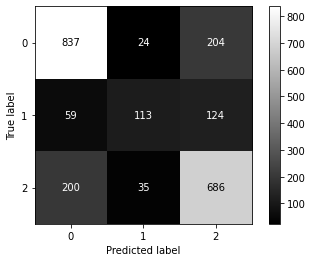

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(Y_validation, softReg.predict(chosen_test), cmap=plt.cm.gray)  
plt.show()

### Learning Curves

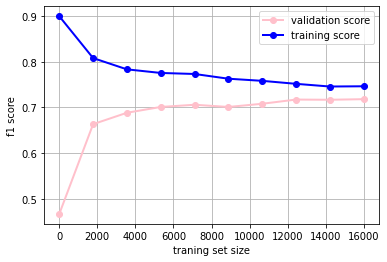

In [ ]:
# parameters 
train_dataset_size = chosen_train.shape[0]
n_train_sizes = 10 # how many points for the plot
estimator = LogisticRegression(multi_class='multinomial', max_iter=1000)
xtrain = chosen_train
ytrain = Y_train
xvalidation = chosen_test
yvalidation = Y_validation

train_sizes = np.linspace(10, train_dataset_size, n_train_sizes, dtype=int)
train_scores = np.zeros(n_train_sizes)
validation_scores = np.zeros(n_train_sizes)

# for each train size find train and validation score
for i in range(n_train_sizes):
  size = train_sizes[i]
  estimator.fit(xtrain[:size, :], ytrain[:size])

  ytrain_pred = estimator.predict(xtrain[:size, :])
  train_scores[i] = f1_score(ytrain[:size], ytrain_pred, average='micro')

  yvalidation_pred = estimator.predict(xvalidation)
  validation_scores[i] = f1_score(yvalidation, yvalidation_pred, average='micro')


# plot
fig, ax = plt.subplots()
ax.plot(train_sizes, validation_scores, "o-", color="pink", lw=2, label='validation score')
ax.plot(train_sizes, train_scores, "o-", color="b", lw=2, label='training score')

ax.set_xlabel('traning set size')
ax.set_ylabel('f1 score')

ax.grid()
ax.legend(loc=0)
plt.show()
  